In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
START_TRAIN_YEAR = "1985-01"
END_TRAIN_YEAR = "2018-12"
START_TEST_YEAR = "2019-01"
END_TEST_YEAR = "2025-12"

In [3]:
def split_train_test(dataset, start_train_date=START_TRAIN_YEAR, end_train_date=END_TRAIN_YEAR, start_test_date=START_TEST_YEAR, end_test_date=END_TEST_YEAR):
    train_data = dataset[(dataset["Year-Month"] >= start_train_date) & (dataset["Year-Month"] <= end_train_date)]
    test_data = dataset[(dataset["Year-Month"] >= start_test_date) & (dataset["Year-Month"] <= end_test_date)]

    return train_data.copy(), test_data.copy()

In [4]:
def standardize(train_X, test_X):
    scaler = StandardScaler()

    # Compute the mean and standard deviation of the training set
    scaler.fit(train_X.loc[:, 'StckUse_US':'Business_Cycle_Weight'])

    # Transform the training and testing sets
    train_X.loc[:, 'StckUse_US':'Business_Cycle_Weight'] = scaler.transform(train_X.loc[:, 'StckUse_US':'Business_Cycle_Weight'])
    test_X.loc[:, 'StckUse_US':'Business_Cycle_Weight'] = scaler.transform(test_X.loc[:, 'StckUse_US':'Business_Cycle_Weight'])

    return train_X, test_X

In [5]:
input_dataset = pd.read_csv("dataset/model_dataset.csv").drop("Unnamed: 0", axis=1)

In [6]:
train_data, test_data = split_train_test(input_dataset)

train_date = train_data.pop("Year-Month")
test_date = test_data.pop("Year-Month")

train_X, train_y = train_data, train_data.pop('Wheat')
test_X, test_y = test_data, test_data.pop('Wheat')

model = LinearRegression(fit_intercept=True, n_jobs=-1)

model.fit(train_X, train_y)

predictions = model.predict(train_X)

test_predictions = model.predict(test_X)

In [7]:
train_X = sm.add_constant(train_X)
sm_model = sm.OLS(train_y, train_X).fit()
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Wheat   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     242.9
Date:                Mon, 05 May 2025   Prob (F-statistic):          2.30e-162
Time:                        18:15:41   Log-Likelihood:                -2249.8
No. Observations:                 408   AIC:                             4522.
Df Residuals:                     397   BIC:                             4566.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  -714.9566    228.354     -3.131      0.002   -1163.891    -266.022
StckUse_US               -0.9917      0.311     -3.188      0.002      -1.603      -0.380
StckUse_World            -6.8850      1.332     -5.167      0.000      -9.505      -4.265
Urea                      0.1117      0.060      1.860      0.064      -0.006       0.230
WTI                       1.9750      0.277      7.142      0.000       1.431       2.519
Dollar                    1.0135      0.359      2.820      0.005       0.307       1.720
MM_Net                    0.0013      0.000     10.977      0.000       0.001       0.002
MM_Categorical          -21.4474     23.410     -0.916      0.360     -67.470      24.575
Seasonality_Weight      758.8269    223.541      3.395      0.001     319.355    1198.299
Uncertain               -30.6277      9.617     -3.185      0.002     -49.534     -11.721
Business_Cycle_Weight   645.5725     58.612     11.014      0.000     530.344     760.801
==============================================================================
Omnibus:                       35.463   Durbin-Watson:                   0.317
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              127.052
Skew:                           0.274   Prob(JB):                     2.58e-28
Kurtosis:                       5.678   Cond. No.                     3.33e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.33e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
train_predictions = pd.DataFrame({"Predicted_price": predictions, "Year-Month": train_date})
test_predictions = pd.DataFrame({"Predicted_price": test_predictions, "Year-Month": test_date})

df_predictions = pd.concat([train_predictions, test_predictions])
full_dates = [datetime.strptime(date, '%Y-%m') for date in df_predictions["Year-Month"]]
train_dates = [datetime.strptime(date, '%Y-%m') for date in train_predictions["Year-Month"]]
test_dates = [datetime.strptime(date, '%Y-%m') for date in test_predictions["Year-Month"]]

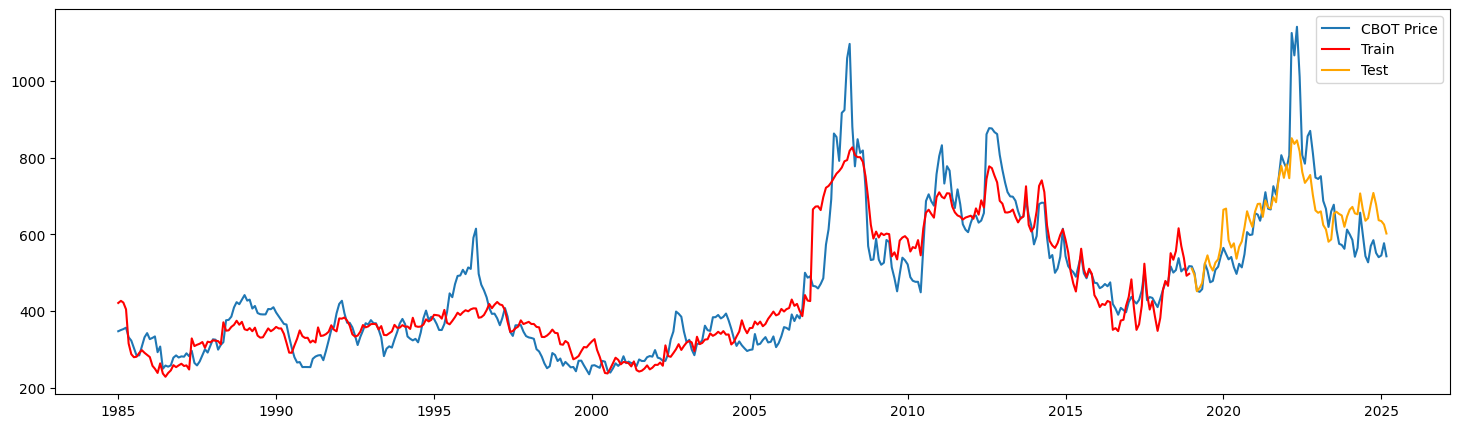

Last wheat average price as of 2025-03 : 543.17
Model prediction of wheat average price as of 2025-03 : 602.50


In [23]:
fig, ax = plt.subplots(figsize=(18, 5))
plt.plot(full_dates, input_dataset["Wheat"], label="CBOT Price")
plt.plot(train_dates, train_predictions["Predicted_price"], label="Train", color="red")
plt.plot(test_dates, test_predictions["Predicted_price"], label="Test", color="orange")
plt.legend()
plt.show()

print(f"Last wheat average price as of {input_dataset['Year-Month'].iloc[-1]} : {input_dataset['Wheat'].iloc[-1]:.2f}")
print(f"Model prediction of wheat average price as of {test_predictions['Year-Month'].iloc[-1]} : {test_predictions['Predicted_price'].iloc[-1]:.2f}")

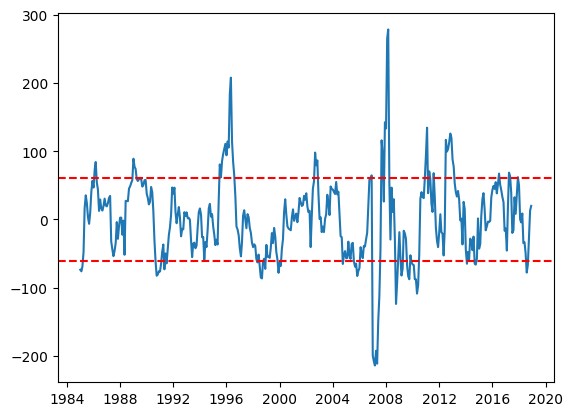

In [34]:
resid = pd.DataFrame({"Date": train_dates, "Resid": sm_model.resid})
plt.plot(resid["Date"], resid["Resid"])
plt.axhline(resid["Resid"].std(), color='red', linestyle='--')
plt.axhline(-resid["Resid"].std(), color='red', linestyle='--')

In [31]:
sm_model.resid

0     -73.605061
1     -75.924822
2     -69.006217
3     -47.712159
4      16.355474
         ...    
403   -77.803749
404   -66.191333
405   -27.732657
406    12.763778
407    19.859935
Length: 408, dtype: float64